In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, AllChem
from rdkit.Chem.Draw import IPythonConsole

from itertools import combinations

import IPython
from IPython.display import display, Image
from PIL import Image

import numpy as np
import pandas as pd

import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("SMILES_Big_Data_Set.csv")
df.head(5)

,SMILES,pIC50,mol,num_atoms,logP
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26,<rdkit.Chem.rdchem.Mol object at 0x7f59df45bc30>,25,4.1591
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c9e0>,36,3.6743
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cac0>,23,1.5361
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cba0>,22,0.9510
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c7b0>,21,3.2130


'Click on the photo to zoom it'

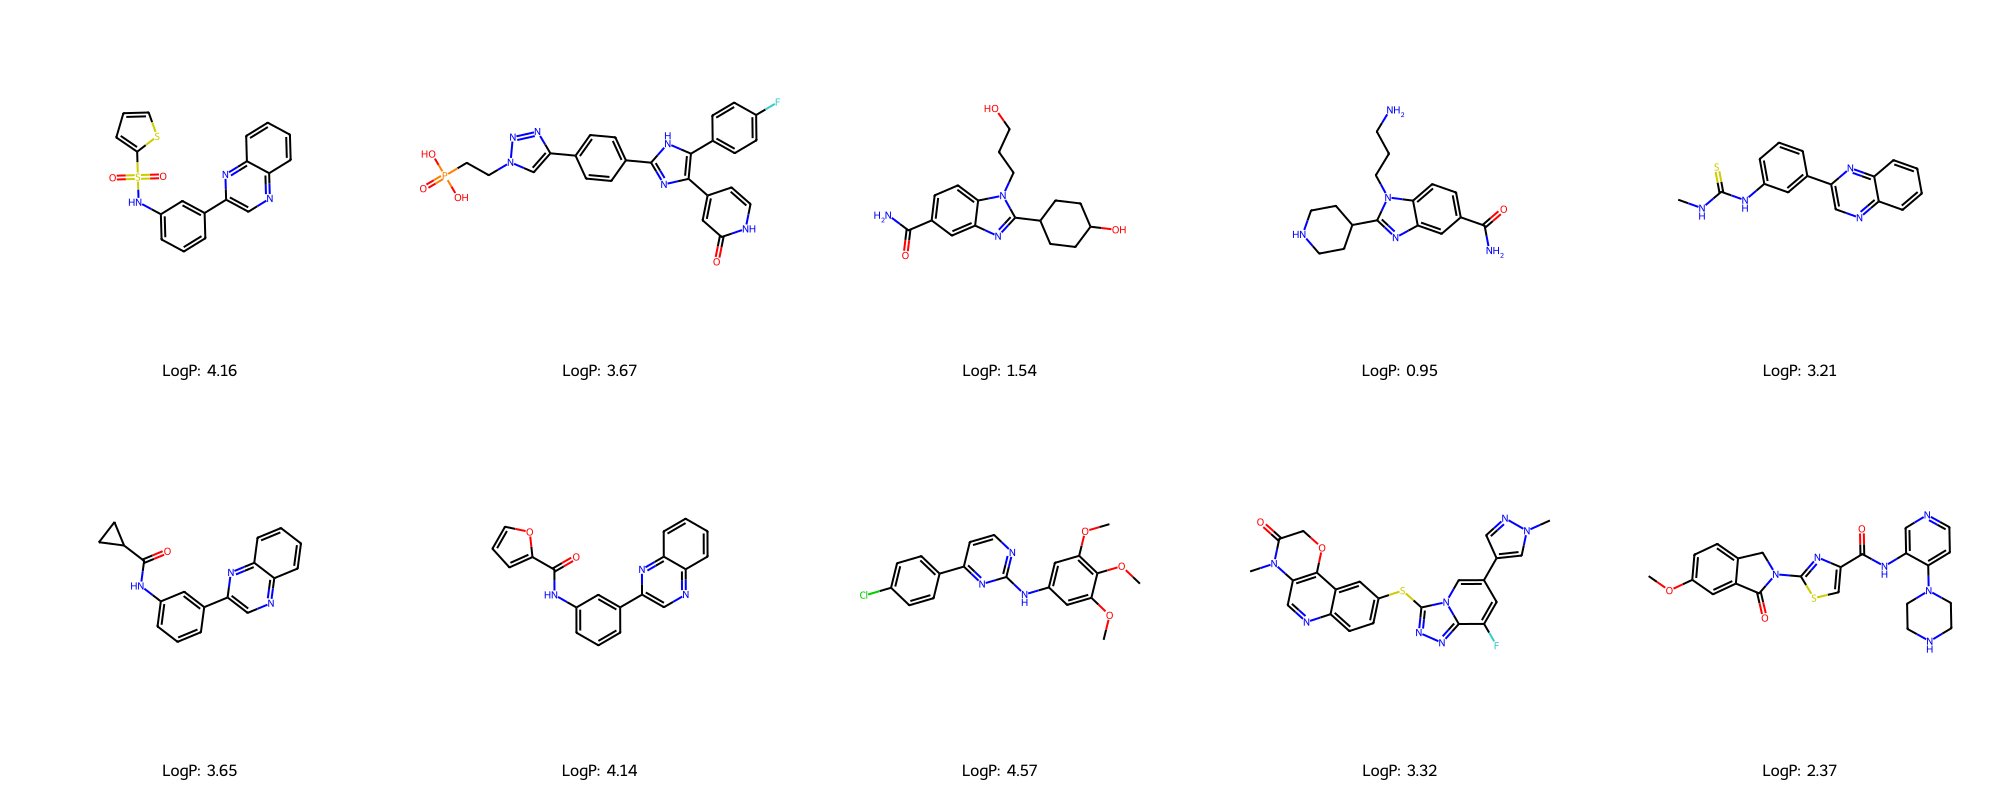

In [3]:
def show_smiles(smiles):
  """
  generate 2D representations of the molecules and color-code them by logP
  :param data_frame: list of smiles
  """
  # Convert the SMILES strings to RDKit molecules
  molecules = [Chem.MolFromSmiles(smile) for smile in smiles]

  # Draw the first molecules
  img = Draw.MolsToGridImage(molecules[:10], molsPerRow=5, subImgSize=(400,400),
                             legends=[f'LogP: {round(x, 2)}' for x in df['logP']], 
                             returnPNG=False).save("molecules.png")
                             
  from IPython.display import display, Image
  display("Click on the photo to zoom it")
  display(Image("molecules.png"))

show_smiles(df["SMILES"])

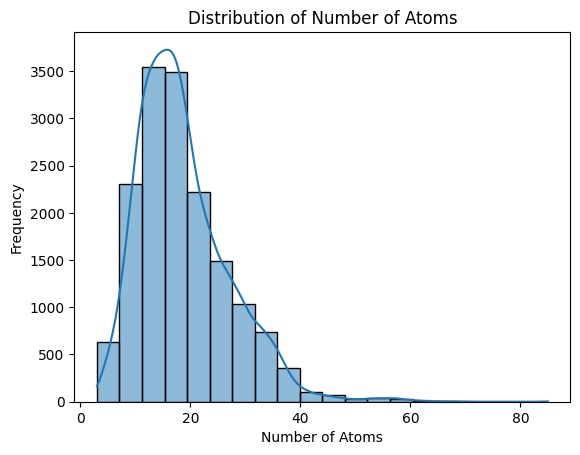

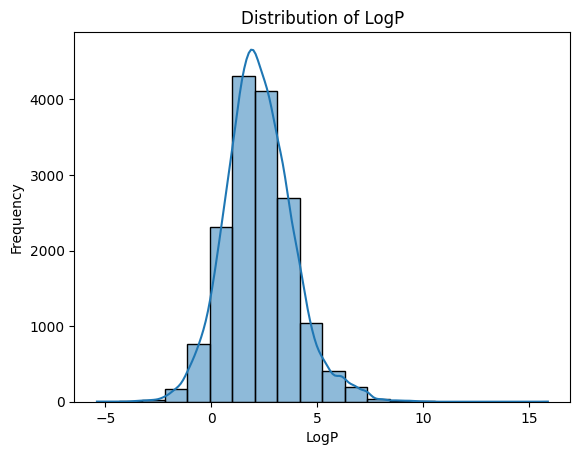

In [4]:
def histogram_of_distribution(data_frame):
  """
  visualize the distribution Number of Atoms and Distribution of LogP 
  :param data_frame: DF with num_atoms & logP
  """
  sns.histplot(data=df, x='num_atoms', bins=20, kde=True)
  plt.title('Distribution of Number of Atoms')
  plt.xlabel('Number of Atoms')
  plt.ylabel('Frequency')
  plt.show()

  sns.histplot(data=df, x='logP', bins=20, kde=True)
  plt.title('Distribution of LogP')
  plt.xlabel('LogP')
  plt.ylabel('Frequency')
  plt.show()

histogram_of_distribution(df)

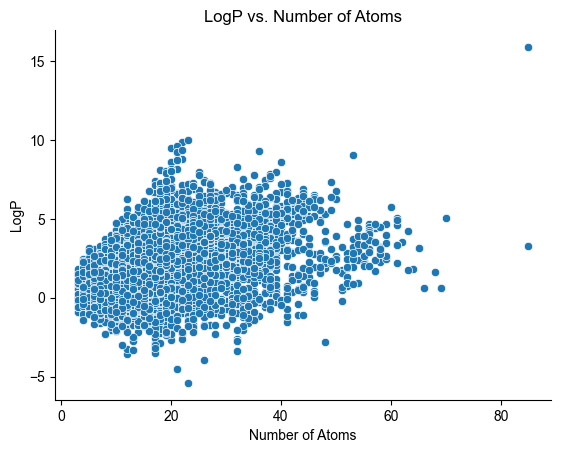

In [5]:
def num_atoms_and_logP(data_frame):
  """
  plot the relationship between logP and number of atoms
  :param data_frame: DF with num_atoms & logP
  """
  sns.scatterplot(data=data_frame, x='num_atoms', y='logP')
  sns.despine()
  sns.set_style("whitegrid")
  plt.title('LogP vs. Number of Atoms')
  plt.xlabel('Number of Atoms')
  plt.ylabel('LogP')
  plt.show()

num_atoms_and_logP(df)

In [6]:
def molecular_weight(smiles_list, pIC50):
  """
  Plot a scatter plot of pIC50 values against molecular weight
  :param smiles_list: A list of SMILES strings
  :param pIC50: A list of SMILES strings
  """
  plt.scatter(smiles_list, pIC50)
  plt.xlabel("Molecular Weight")
  plt.ylabel("pIC50")
  plt.title("pIC50 vs Molecular Weight")
  plt.show()

# molecular_weight(df["SMILES"], df["pIC50"])

In [7]:
html_code = \
'''
<p>This is a 3D object you can interact with it!</p>
<iframe style="width: 900px; height: 900px;" frameborder="0" src="https://embed.molview.org/v1/?mode=balls&cid=127050563"></iframe>
'''
display(IPython.display.HTML(html_code))

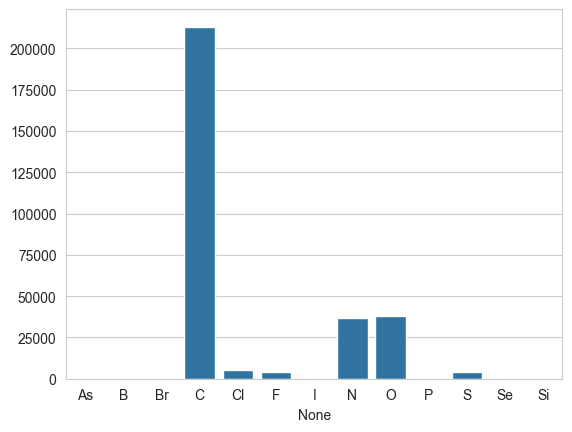

In [8]:
def atom_frequency(smiles_list):
    """
    frequency of different atom types in SMILES
    :param smiles_list: A list of SMILES strings
    """
    atom_counts = []
    for smiles in smiles_list:
        # Convert the SMILES string to an RDKit molecule object
        mol = Chem.MolFromSmiles(smiles)
        # Get the atoms in the molecule
        atoms = mol.GetAtoms()
        # Add the symbol for each atom to the atom_counts list
        atom_counts.extend([atom.GetSymbol() for atom in atoms])

    # Create a pandas series with the counts of each atom type
    plot_data = pd.Series(atom_counts).value_counts().sort_index()
    sns.barplot(x=plot_data.index, y=plot_data.values)

atom_frequency(df['SMILES'])

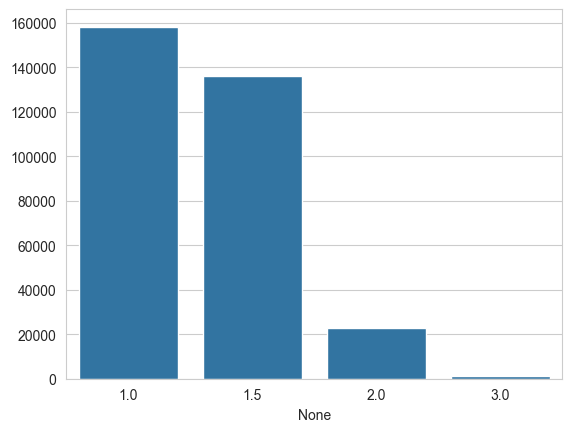

In [9]:
def bond_frequency(smiles_list):
    """
    Frequency of different bond types
    :param smiles_list: A list of SMILES strings
    """
    bond_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        bonds = mol.GetBonds()
        # Loop through each bond in the molecule and append its bond type to the bond_counts list
        bond_counts.extend([bond.GetBondTypeAsDouble() for bond in bonds])
    # Count the frequency of each bond type and sort the counts in ascending order
    plot_data = pd.Series(bond_counts).value_counts().sort_index()
    sns.barplot(x=plot_data.index, y=plot_data.values)

bond_frequency(df['SMILES'])

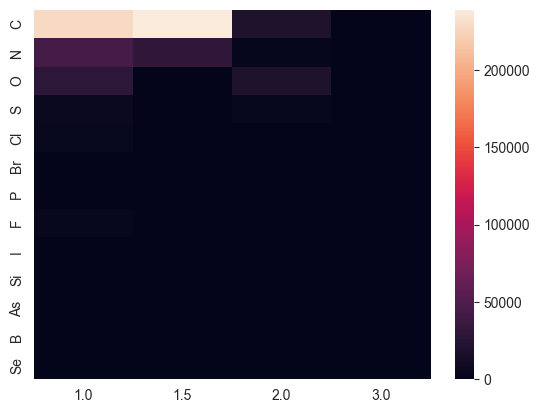

In [10]:
def atom_bond_heatmap(smiles_list):
    """
    The pairwise occurrences of different atom and bond types
    :param smiles_list: A list of SMILES strings
    """
    # Define the atom and bond types to consider
    atom_types = ['C', 'N', 'O', 'S', 'Cl', 'Br', 'P', 'F', 'I', 'Si', 'As', 'B', 'Se']
    bond_types = [1.0, 1.5, 2.0, 3.0]
    # Initialize the data array with zeros
    data = np.zeros((len(atom_types), len(bond_types)))
    for smiles in smiles_list:
        # Convert the SMILES string to a molecule object
        mol = Chem.MolFromSmiles(smiles)
        # Get the atoms and bonds in the molecule
        atoms = mol.GetAtoms()
        bonds = mol.GetBonds()
        # Get the atoms and bonds in the molecule
        for bond in bonds:
            # Get the bond type and index in the bond_types list
            bond_type = bond.GetBondTypeAsDouble()
            bond_idx = bond_types.index(bond_type)
            # Update the data array for each atom in the bond
            for atom in [bond.GetBeginAtom(), bond.GetEndAtom()]:
                # Get the atom type and index in the atom_types list
                atom_type = atom.GetSymbol()
                atom_idx = atom_types.index(atom_type)
                # Increment the count in the data array for the atom-bond pair
                data[atom_idx, bond_idx] += 1
    sns.heatmap(data, xticklabels=bond_types, yticklabels=atom_types)

atom_bond_heatmap(df["SMILES"])

In [11]:
def fingerprint_tsne(smiles_list):
    """
    Plot a t-SNE plot of the molecular fingerprints for a list of SMILES strings
    :param smiles_list: A list of SMILES strings
    """
    from sklearn.manifold import TSNE
    from rdkit.Chem import AllChem
    # Generate molecular fingerprints using Morgan algorithm with radius=2
    fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles),
                                                 2) for smiles in smiles_list]
    # Convert the list of fingerprints to a numpy array
    fps_array = np.asarray(fps)
    tsne = TSNE(n_components=2)
    tsne_result = tsne.fit_transform(fps_array)
    sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1])

# fingerprint_tsne(df['SMILES'])

[22:58:28] DEPRECATION WARNING: please use MorganGenerator
[22:58:28] DEPRECATION WARNING: please use MorganGenerator
[22:58:28] DEPRECATION WARNING: please use MorganGenerator
[22:58:28] DEPRECATION WARNING: please use MorganGenerator
[22:58:28] DEPRECATION WARNING: please use MorganGenerator
[22:58:28] DEPRECATION WARNING: please use MorganGenerator
[22:58:28] DEPRECATION WARNING: please use MorganGenerator
[22:58:28] DEPRECATION WARNING: please use MorganGenerator
[22:58:28] DEPRECATION WARNING: please use MorganGenerator
[22:58:28] DEPRECATION WARNING: please use MorganGenerator
[22:58:28] DEPRECATION WARNING: please use MorganGenerator
[22:58:28] DEPRECATION WARNING: please use MorganGenerator
[22:58:28] DEPRECATION WARNING: please use MorganGenerator
[22:58:28] DEPRECATION WARNING: please use MorganGenerator
[22:58:28] DEPRECATION WARNING: please use MorganGenerator


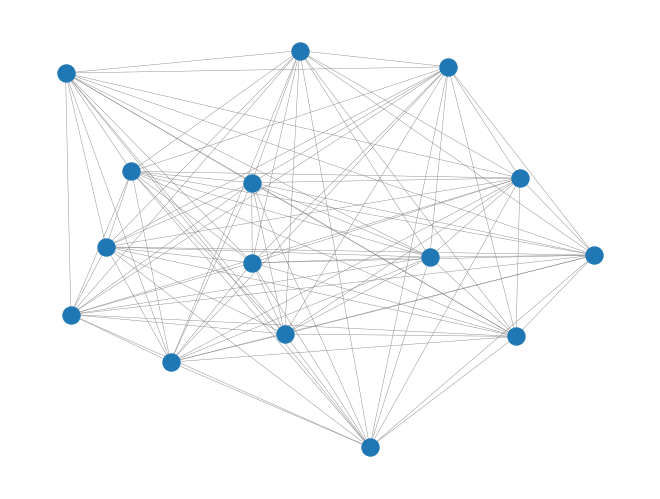

In [12]:
def molecular_similarity(smiles_list):
  # Generate molecular fingerprints using Morgan algorithm with radius=2
  fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 2) for smiles in smiles_list]

  # Calculate pairwise similarity scores using *(Tanimoto similarity coefficient)
  similarity_scores = []
  for fp1, fp2 in combinations(fps, 2):
      similarity_score = DataStructs.TanimotoSimilarity(fp1, fp2)
      similarity_scores.append(similarity_score)

  # Build a similarity network using NetworkX
  G = nx.Graph()
  for idx, smiles in enumerate(smiles_list):
      G.add_node(idx, smiles=smiles)
  for (i, j), weight in zip(combinations(range(len(smiles_list)), 2), similarity_scores):
      G.add_edge(i, j, weight=weight)

  # Visualize the network
  pos = nx.spring_layout(G)
  nx.draw(G, pos=pos, node_size=150, width=0.3, edge_color='gray', with_labels=False)
  plt.show()

short_df_for_grahp = df.head(15)
molecular_similarity(short_df_for_grahp["SMILES"])


{'Molecular Weight': 180.15899999999996, 'LogP': 1.3101, 'H-Bond Donor Count': 1, 'H-Bond Acceptor Count': 3}

1/1 [==============================] - 0s 160ms/step
Model Output: [[-14.554232 -22.295908  15.80617 ]]
Reconstructed SMILES: CC(=O)Oc1ccccc1C(=O)O


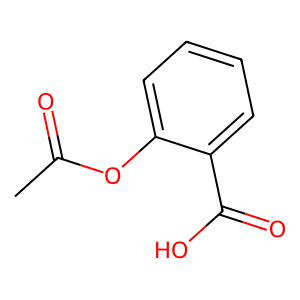

In [13]:
import re
import random

import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import MolToImage

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


class DRLAgent:
    """
    Deep Reinforcement Learning Agent

    Args:
        state_size (int): Size of the state space
        action_size (int): Size of the action space
    """

    def __init__(self, state_size, action_size, selected_X_train):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        # discount rate
        self.gamma = 0.95
        # exploration rate
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.selected_X_train = selected_X_train
        self.model = self._build_model(selected_X_train)
        # target model for stability
        self.target_model = self._build_model(selected_X_train) 
        self.update_target_model()

    def _build_model(self, selected_X_train):
        """
        Build the Deep Q-Network model

        Returns:
            model (Sequential): Deep Q-Network model
        """
        model = Sequential()
        model.add(Dense(32, input_shape=(selected_X_train.shape[1],), activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        """Update the target model weights with the current model weights"""
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """
        Store the experience in the replay memory

        Args:
            state (ndarray): Current state
            action (int): Action taken
            reward (float): Reward received
            next_state (ndarray): Next state
            done (bool): Whether the episode is done
        """
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """
        Choose an action given the current state

        Args:
            state (ndarray): Current state

        Returns:
            action (int): Chosen action
        """
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        if state is None:
            state = np.zeros((1, self.state_size))
        else:
            state = state.reshape(1, self.state_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        """
        Train the model by replaying experiences from the replay memory

        Args:
            batch_size (int): Size of the minibatch
        """
        # Sample a minibatch of experiences from the replay memory
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            if state is not None:
                if not done:
                    # Calculate the target value using the target model
                    target = (reward + self.gamma * np.amax(self.target_model.predict(next_state)[0]))
                else:
                    target = reward
                # Make the agent approximately map the current state to future discounted reward
                target_f = self.model.predict(state)
                target_f[0][action] = target
                # Train the model using the current state and target value
                self.model.fit(state, target_f, epochs=1, verbose=0)
        # Decay the exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        """Load the model weights from a file"""
        self.model.load_weights(name)

    def save(self, name):
        """Save the model weights to a file"""
        self.model.save_weights(name)


def preprocess_smiles(smiles):
    """
    Preprocess the SMILES string by removing salts and stereochemistry information

    Args:
        smiles (str): SMILES string

    Returns:
        preprocessed_smiles (str): Preprocessed SMILES string
    """
    # Remove salts
    preprocessed_smiles = re.sub(r'\[.*?\]', '', smiles)
    # Remove stereochemistry information
    preprocessed_smiles = re.sub(r'[@]\S*', '', preprocessed_smiles)
    return preprocessed_smiles


def calculate_molecular_properties(smiles):
    """
    Calculate molecular properties of a compound given its SMILES string

    Args:
        smiles (str): SMILES string

    Returns:
        properties (dict): Dictionary of molecular properties
    """
    molecule = Chem.MolFromSmiles(smiles)
    properties = {}

    if molecule is not None:
        properties['Molecular Weight'] = Descriptors.MolWt(molecule)
        properties['LogP'] = Descriptors.MolLogP(molecule)
        properties['H-Bond Donor Count'] = Descriptors.NumHDonors(molecule)
        properties['H-Bond Acceptor Count'] = Descriptors.NumHAcceptors(molecule)

    return properties


if __name__ == '__main__':
    smiles = 'CC(=O)OC1=CC=CC=C1C(=O)O'
    preprocessed_smiles = preprocess_smiles(smiles)
    properties = calculate_molecular_properties(preprocessed_smiles)
    print(properties) # {'Molecular Weight': 180.15899999999996, 'LogP': 1.3101, 'H-Bond Donor Count': 1, 'H-Bond Acceptor Count': 3}
    
    # Convert the properties dictionary to a NumPy array
    selected_X_train = np.array(list(properties.values())).reshape(1, -1)

    agent = DRLAgent(state_size=selected_X_train.shape[1], action_size=3, selected_X_train=selected_X_train)

    # Get the model's output for the selected input
    output = agent.model.predict(selected_X_train)
    print("Model Output:", output)

    # Obtain the SMILES representation of the molecule after processing with the model
    reconstructed_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(preprocessed_smiles))
    print("Reconstructed SMILES:", reconstructed_smiles)
    
    mol = Chem.MolFromSmiles(reconstructed_smiles)
    if mol is None:
        print(f"Error generating molecule from SMILES: {reconstructed_smiles}")
    else:
        display(MolToImage(mol))